In [1]:
from __future__ import division
import torch
import numpy as np
import torch.optim as optim
from torch import nn
import matplotlib.pyplot as plt
from utils import load_metr_la_rdata, get_normalized_adj, get_Laplace, calculate_random_walk_matrix,test_error
import random
import pandas as pd
from basic_structure import D_GCN, C_GCN, K_GCN,IGNNK
import geopandas as gp
import matplotlib as mlt

/home/dingyizhuang/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Define the hyper parameters

In [2]:
n_o_n_m = 150 #sampled space dimension

h = 24 #sampled time dimension

z = 100 #hidden dimension for graph convolution

K = 1 #If using diffusion convolution, the actual diffusion convolution step is K+1

n_m = 50 #number of mask node during training

N_u = 50 #target locations, N_u locations will be deleted from the training data

Max_episode = 750 #max training episode

learning_rate = 0.0001 #the learning_rate for Adam optimizer

E_maxvalue = 80 #the max value from experience

batch_size = 4 

Build the IGNNK model

In [3]:
STmodel = IGNNK(h, z, K)  # The graph neural networks

Load data

In [4]:
A, X = load_metr_la_rdata()

split_line1 = int(X.shape[2] * 0.7)

training_set = X[:, 0, :split_line1].transpose()

test_set = X[:, 0, split_line1:].transpose()       # split the training and test period

rand = np.random.RandomState(0) # Fixed random output
unknow_set = rand.choice(list(range(0,X.shape[0])),N_u,replace=False)
unknow_set = set(unknow_set)
full_set = set(range(0,207))        
know_set = full_set - unknow_set
training_set_s = training_set[:, list(know_set)]   # get the training data in the sample time period
A_s = A[:, list(know_set)][list(know_set), :]      # get the observed adjacent matrix from the full adjacent matrix,
                                                   # the adjacent matrix are based on pairwise distance, 
                                                   # so we need not to construct it for each batch, we just use index to find the dynamic adjacent matrix

Train the IGNNK model

In [5]:
criterion = nn.MSELoss()
optimizer = optim.Adam(STmodel.parameters(), lr=learning_rate)
RMSE_list = []
MAE_list = []
MAPE_list = []
for epoch in range(Max_episode):
    for i in range(training_set.shape[0]//(h * batch_size)):  #using time_length as reference to record test_error
        t_random = np.random.randint(0, high=(training_set_s.shape[0] - h), size=batch_size, dtype='l')
        know_mask = set(random.sample(range(0,training_set_s.shape[1]),n_o_n_m)) #sample n_o + n_m nodes
        feed_batch = []
        for j in range(batch_size):
            feed_batch.append(training_set_s[t_random[j]: t_random[j] + h, :][:, list(know_mask)]) #generate 8 time batches
        
        inputs = np.array(feed_batch)
        inputs_omask = np.ones(np.shape(inputs))
        inputs_omask[inputs == 0] = 0           # We found that there are irregular 0 values for METR-LA, so we treat those 0 values as missing data,
                                                # For other datasets, it is not necessary to mask 0 values
                                                
        missing_index = np.ones((inputs.shape))
        for j in range(batch_size):
            missing_mask = random.sample(range(0,n_o_n_m),n_m) #Masked locations
            missing_index[j, :, missing_mask] = 0
            
        Mf_inputs = inputs * inputs_omask * missing_index / E_maxvalue #normalize the value according to experience
        Mf_inputs = torch.from_numpy(Mf_inputs.astype('float32'))
        mask = torch.from_numpy(inputs_omask.astype('float32'))   #The reconstruction errors on irregular 0s are not used for training
        
        A_dynamic = A_s[list(know_mask), :][:, list(know_mask)]   #Obtain the dynamic adjacent matrix
        A_q = torch.from_numpy((calculate_random_walk_matrix(A_dynamic).T).astype('float32'))
        A_h = torch.from_numpy((calculate_random_walk_matrix(A_dynamic.T).T).astype('float32'))
        
        outputs = torch.from_numpy(inputs/E_maxvalue) #The label
        
        optimizer.zero_grad()
        X_res = STmodel(Mf_inputs, A_q, A_h)  #Obtain the reconstruction
        
        loss = criterion(X_res*mask, outputs*mask)
        loss.backward()
        optimizer.step()        #Errors backward
    
    MAE_t, RMSE_t, MAPE_t, metr_ignnk_res  = test_error(STmodel, unknow_set, test_set, A,E_maxvalue, True)
    RMSE_list.append(RMSE_t)
    MAE_list.append(MAE_t)
    MAPE_list.append(MAPE_t)
    if epoch%50 == 0:
        print(epoch, MAE_t, RMSE_t, MAPE_t)
#torch.save(STmodel.state_dict(), 'model/IGNNK.pth') # Save the model

0 18.639497711996494 26.521284291053814 0.4166372011799799
50 7.281889978708868 10.498647477816302 0.20560539899238858
100 7.090598814658964 10.32365849540285 0.1984995086723587
150 6.811448273279633 10.362670854450258 0.19682390595360505
200 6.903488501259584 10.243904547871125 0.19377670226250568
250 6.845291201511475 10.34761631746015 0.19752768116802832
300 6.944085474222253 10.251000567744677 0.1955551790270926
350 7.068088910235515 10.239781009131354 0.19701760874256305
400 7.0779365661528955 10.175076801197745 0.19568528109780828
450 7.0968751176219005 10.226519360210505 0.19836896562460826
500 7.3540931025767895 10.277390631897553 0.19955214108083866
550 7.406451876296461 10.22873449644766 0.1979081333491295
600 7.3316827519052685 10.208187053005437 0.19923418387861833
650 7.371843821410239 10.141792952256504 0.19487019175622808
700 6.976510149897158 10.1968037073599 0.19652314349197356


Draw Learning curves on testing error

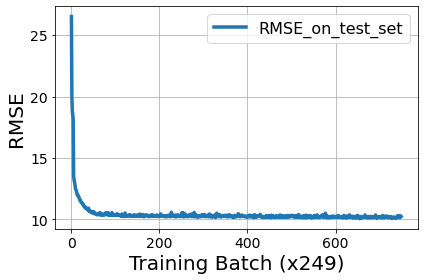

In [6]:
fig,ax = plt.subplots()
ax.plot(RMSE_list,label='RMSE_on_test_set',linewidth=3.5)
ax.set_xlabel('Training Batch (x249)',fontsize=20)
ax.set_ylabel('RMSE',fontsize=20)
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)
ax.legend(fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.savefig('fig/ignnk_learning_curve_metr-la.pdf')

Draw spatial information of METR-LA kriging

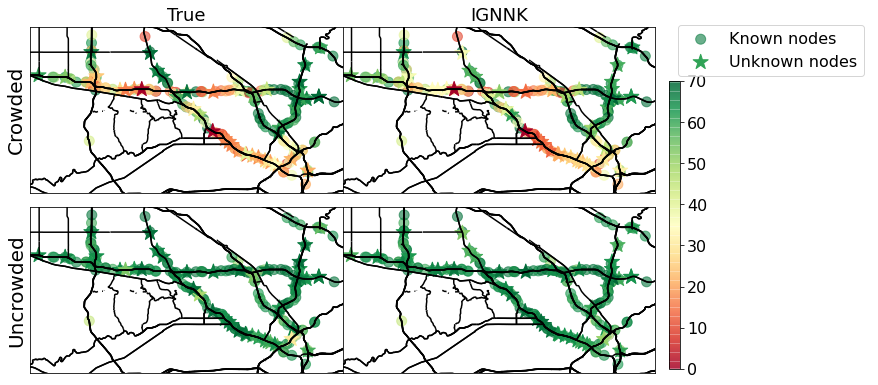

In [7]:
url_census='data/metr/Census_Road_2010_shapefile/Census_Road_2010.shp'
meta_locations = pd.read_csv('data/metr/graph_sensor_locations.csv')
map_metr=gp.read_file(url_census,encoding="utf-8")
fig,axes = plt.subplots(2,2,figsize = (10,5))
lng_div = 0.01
lat_div = 0.01
crowd = [127,160] #crowd and uncrowd, in the test time slice
ylbs = ['Crowded','Uncrowded']

for row in range(2):
    for col in range(2):
        ax = axes[row,col]
        map_metr.plot(ax=ax,color='black')
        ax.set_xlim((np.min(meta_locations['longitude'])-lng_div,np.max(meta_locations['longitude'])+lng_div))
        ax.set_ylim((np.min(meta_locations['latitude'])-lat_div,np.max(meta_locations['latitude'])+lat_div))
        ax.set_xticks([])
        ax.set_yticks([])
        if col == 0:
            cax=ax.scatter(meta_locations['longitude'][list(know_set)],meta_locations['latitude'][list(know_set)],s=100,cmap=plt.cm.RdYlGn, c = test_set[crowd[row],list(know_set)],
              norm=mlt.colors.Normalize(vmin=X.min(), vmax = X.max()),alpha=0.6,label='Known nodes')
            cax2=ax.scatter(meta_locations['longitude'][list(unknow_set)],meta_locations['latitude'][list(unknow_set)],s=250,cmap=plt.cm.RdYlGn,c=test_set[crowd[row],list(unknow_set)],
              norm=mlt.colors.Normalize(vmin=X.min(), vmax = X.max()),alpha=1,marker='*',label = 'Unknown nodes')
            ax.set_ylabel(ylbs[row],fontsize=20)
            if row == 0:
                ax.set_title('True',fontsize = 18)
        else:
            ax.scatter(meta_locations['longitude'][list(know_set)],meta_locations['latitude'][list(know_set)],s=100,cmap=plt.cm.RdYlGn, c = test_set[crowd[row],list(know_set)],
              norm=mlt.colors.Normalize(vmin=X.min(), vmax = X.max()),alpha=0.6)
            ax.scatter(meta_locations['longitude'][list(unknow_set)],meta_locations['latitude'][list(unknow_set)],s=250,cmap=plt.cm.RdYlGn,c=metr_ignnk_res[crowd[row],list(unknow_set)],
              norm=mlt.colors.Normalize(vmin=X.min(), vmax = X.max()),alpha=1,marker='*')
            if row == 0:
                ax.set_title('IGNNK',fontsize = 18)

fig.tight_layout()
fig.subplots_adjust(right = 0.9,hspace=0,wspace =0,bottom=0,top=1)
l = 0.92
b = 0.03
w = 0.015
h = 0.8
rect = [l,b,w,h] 
cbar_ax = fig.add_axes(rect) 
cbar = fig.colorbar(cax, cax=cbar_ax)
cbar.ax.tick_params(labelsize=16)

plt.figlegend(handles=(cax,cax2),labels=('Known nodes','Unknown nodes'),bbox_to_anchor=(1.2, 1), loc=1, borderaxespad=0.,fontsize = 16 )
plt.savefig('fig/metr_ignnk_spatial_crowd{:}_uncrowd{:}.pdf'.format(crowd[0],crowd[1]))
plt.show()

Draw temporal information of METR-LA kriging

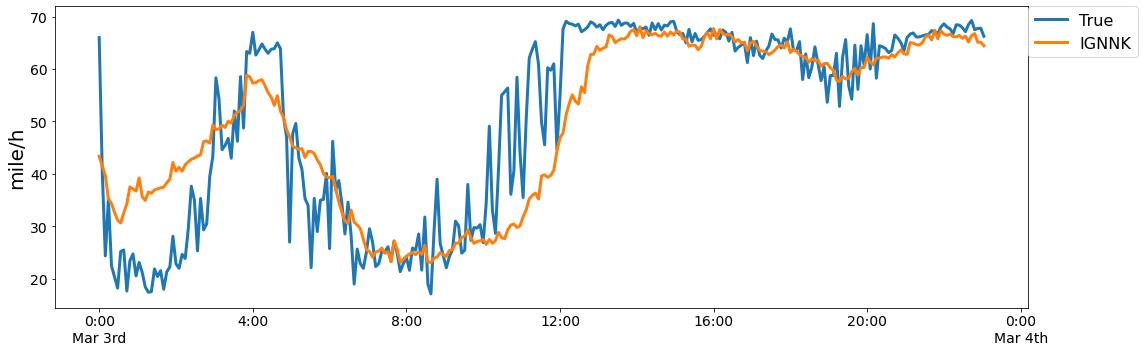

In [8]:
fig,ax = plt.subplots(figsize = (16,5))
s = int(6400-64 )
e = int(s + 24*60/5+1)
station = list(unknow_set)[24]
ax.plot(test_set[s:e,station],label='True',linewidth=3)
ax.plot(metr_ignnk_res[s:e,station],label='IGNNK',linewidth = 3)
ax.set_ylabel('mile/h',fontsize=20)
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)
ax.set_xticks(range(0,350,50))
ax.set_xticklabels(['0:00\nMar 3rd','4:00','8:00','12:00','16:00','20:00','0:00\nMar 4th'])
ax.legend(bbox_to_anchor=(1, 1), loc=0, borderaxespad=0,fontsize=16)
plt.tight_layout()
plt.savefig('fig/metr_ignnk_temporal.pdf')
plt.show()